<a href="https://colab.research.google.com/github/lisalisa2/PROJ-H409-Lisa-W/blob/main/CNN_for_pneumonia_ct_scan_classificaation_Lisa_W.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**First we need to download the dataset from Kaggle**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lisalisa2","key":"26ed732b1070ee012e53dde72ec71e4d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 1.5MB 8.0MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 3.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=271fc40b8c28ea31060fb55105876d90f32f1ba9b3a826eca139fb52ffc48b7b
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
Kaggle API 1.5.6


In [ ]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [01:16<00:00, 30.0MB/s]
100% 3.66G/3.66G [01:16<00:00, 51.5MB/s]


In [ ]:
!unzip rsna-pneumonia-detection-challenge.zip 

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_trai

In [ ]:
!pip install pydicom
import glob, pylab, pandas as pd
import pydicom, numpy as np

     |████████████████████████████████| 1.9 MB 8.3 MB/s 


****

**Read the different files**

In [ ]:
#method to read the data provided in the dcm and csv files
def parse_data(df):
  
    parsed = {}
    for n, row in df.iterrows():
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': 'stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
  }

    return parsed

**CSV labels file**

In [ ]:
#read the data provided in the labels csv file
df = pd.read_csv('stage_2_train_labels.csv')
parsed = parse_data(df) 

In [ ]:
#information contained in the csv file for the first patient
#this patient doesn't have pneumonia (label 0)
#x,y,width,height are the coordonates for the bounding boxes (not used in this project)
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


**Train stage dcm file**

In [ ]:
#here we read the metadata from the dicom file of the fourth patient
#we are interest in the pixel array (matrix of pixels forming the ct-scan)
patientId = df['patientId'][4]
dcm_file = 'stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

**A ct-scan from the dataset**

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#extracting the matrix of pixels given in the metadata
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

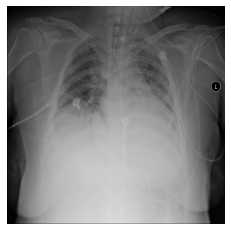

In [ ]:
#plotting the ct-scan
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

**Store labels and images**

In [ ]:
from skimage.transform import resize

In [ ]:
#creating the training set
#we take 2000 images from the 'stage_2_train_images' file

train_data = [] 
train_label = []

df = pd.read_csv('stage_2_train_labels.csv')

for i in range(2000) :

  patientId = df['patientId'][i]
  dcm_file = 'stage_2_train_images/%s.dcm' % patientId
  dcm_data = pydicom.read_file(dcm_file)

  im = dcm_data.pixel_array

  #resizing the images because initial size was 1024x1024
  im_resized = resize(im,(256,256))
  
  #store all the images in the train_data list
  #store all the corresponding labels in the train_label list 
  train_data.append(im_resized) 
  train_label.append(df['Target'][i])

In [ ]:
#converting the training set and labels list into arrays to be compatible with Keras
x_train = np.array(train_data) 
y_train = np.array(train_label)

In [ ]:
#create the validation set
#we take 200 images from the 'stage_2_train_images' file (10% of the training set), differents from the ones in the training set
val_data = []
val_label = []

for i in range(2001, 2201) :

  patientId = df['patientId'][i]
  dcm_file = 'stage_2_train_images/%s.dcm' % patientId
  dcm_data = pydicom.read_file(dcm_file)

  im = dcm_data.pixel_array

  im_resized = resize(im,(256,256))

  val_data.append(im_resized) 
  val_label.append(df['Target'][i])

In [ ]:
x_val = np.array(val_data)
y_val = np.array(val_label)

In [ ]:
#create the validation set
#we take the 150 images from the 'stage_2_train_images' file (different images than training set and validation set)

test_data = []
test_label = []

for i in range(2202, 2352) :

  patientId = df['patientId'][i]
  dcm_file = 'stage_2_train_images/%s.dcm' % patientId
  dcm_data = pydicom.read_file(dcm_file)

  im = dcm_data.pixel_array

  im_resized = resize(im,(256,256))

  test_data.append(im_resized) 
  test_label.append(df['Target'][i])

In [ ]:
x_test = np.array(test_data)
y_test = np.array(test_label)

**Preprocessing**

In [ ]:
#inital shape (2000, 256, 256) not compatible with keras
#reshape the data to (2000, 256, 256, 1)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [ ]:
print(x_train.shape) 
print(x_val.shape) 
print(x_test.shape) 

(2000, 256, 256, 1)
(200, 256, 256, 1)
(150, 256, 256, 1)


In [ ]:
#inital type of labels sets not compatible with keras
#reshape labels sets 
y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
y_val = np.asarray(val_label).astype('float32').reshape((-1,1))
y_test = np.asarray(test_label).astype('float32').reshape((-1,1))

Now we need to transform our label so that they are in the good format to use the softmax activation function in the model. 

Initially the labels are 0 if no pneumonia or 1 if pneumonia.
After one hot encoding, they will be transformed to [1. 0.] or [0. 1.], so that they belong to one of the two following classes ['normal','pneumonia']

So :

label 0 -> [1. 0.]

label 1 -> [0. 1.]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_val_one_hot = one_hot_encoder.transform(y_val)
y_test_one_hot = one_hot_encoder.transform(y_test)

In [ ]:
#an example of the labels after one hot enconding
print(y_train[4])
print(y_train_one_hot[4])

[1.]
[0. 1.]


**Build the CNN**

In [ ]:
#import libraries to build the model
%matplotlib inline
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
#the CNN
model = Sequential()

#first block
model.add(Conv2D(16, (3, 3), padding = 'same', \
                 activation="relu",input_shape = (256,256,1), strides = (1,1)))

model.add(Conv2D(32, (3, 3), padding = 'same',activation="relu",strides = (1,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

#second block
model.add(Conv2D(16, (3, 3), padding = 'same', activation="relu", strides = (1,1)))
model.add(Conv2D(32, (3, 3), padding = 'same',activation="relu",strides = (1,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

#third block
model.add(Conv2D(16, (3, 3), padding = 'same', activation="relu", strides = (1,1)))
model.add(Conv2D(32, (3, 3), padding = 'same',activation="relu",strides = (1,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

#fully connected layers
model.add(Flatten()) 
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(2, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      4624      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 16)        4

In [ ]:
#compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
#train the model
history = model.fit(x_train, y_train_one_hot, epochs = 7, validation_data=(x_val,y_val_one_hot),batch_size=32) 

Epoch 1/7
63/63 [==============================] - 45s 200ms/step - loss: 0.6520 - accuracy: 0.6057 - val_loss: 0.6322 - val_accuracy: 0.7000
Epoch 2/7
63/63 [==============================] - 11s 168ms/step - loss: 0.5181 - accuracy: 0.7384 - val_loss: 0.5749 - val_accuracy: 0.7100
Epoch 3/7
63/63 [==============================] - 11s 167ms/step - loss: 0.4770 - accuracy: 0.7844 - val_loss: 0.5606 - val_accuracy: 0.7450
Epoch 4/7
63/63 [==============================] - 11s 168ms/step - loss: 0.4792 - accuracy: 0.7693 - val_loss: 0.5388 - val_accuracy: 0.7550
Epoch 5/7
63/63 [==============================] - 11s 167ms/step - loss: 0.4386 - accuracy: 0.8004 - val_loss: 0.5930 - val_accuracy: 0.7500
Epoch 6/7
63/63 [==============================] - 11s 168ms/step - loss: 0.3939 - accuracy: 0.8283 - val_loss: 0.5671 - val_accuracy: 0.7550
Epoch 7/7
63/63 [==============================] - 11s 168ms/step - loss: 0.3605 - accuracy: 0.8492 - val_loss: 0.5541 - val_accuracy: 0.7300


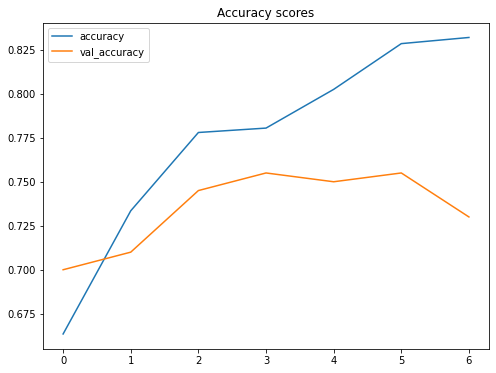

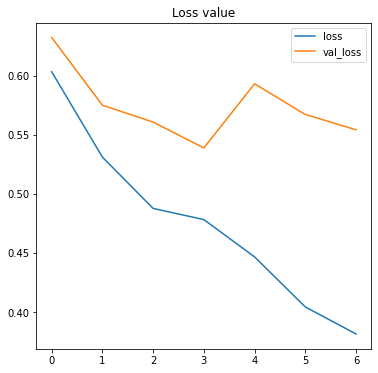

In [ ]:
#plot the accuracy scores and the loss values 
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(6,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

*Test stage*

In [ ]:
#predict results on images in the test set
predictions = model.predict(x_test)

In [ ]:
#predictions (probabilities)
print(predictions)

[[0.08008279 0.91991717]
 [0.08008279 0.91991717]
 [0.82584924 0.17415074]
 [0.4737523  0.5262477 ]
 [0.89899933 0.10100058]
 [0.75937593 0.24062409]
 [0.13014966 0.86985034]
 [0.13014966 0.86985034]
 [0.5026177  0.49738228]
 [0.5026177  0.49738228]
 [0.9131554  0.08684463]
 [0.09635305 0.90364695]
 [0.09635305 0.90364695]
 [0.86819756 0.13180251]
 [0.6519401  0.3480599 ]
 [0.67303336 0.32696664]
 [0.9120863  0.08791373]
 [0.44548863 0.55451137]
 [0.44548863 0.55451137]
 [0.08374845 0.91625154]
 [0.725859   0.27414098]
 [0.36106446 0.63893557]
 [0.81701124 0.18298881]
 [0.9680962  0.03190374]
 [0.23401566 0.76598436]
 [0.23401566 0.76598436]
 [0.7380402  0.26195973]
 [0.7274471  0.2725529 ]
 [0.6764105  0.32358953]
 [0.97660905 0.02339089]
 [0.89124185 0.10875811]
 [0.6241322  0.3758678 ]
 [0.84559697 0.15440296]
 [0.88751584 0.11248411]
 [0.9299971  0.07000291]
 [0.7627358  0.23726416]
 [0.7627358  0.23726416]
 [0.7978755  0.20212449]
 [0.9192338  0.08076616]
 [0.8958825  0.10411752]


In [ ]:
#we take the max value from each couple of probabilities and round it to obtain the predicted labels 
predict_class = np.argmax(predictions, axis=1)
predict = np.asarray(predict_class).astype('float32').reshape((-1,1))
print(predict)

[[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]]


*Confusion matrix and precision*

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(y_test,predict)

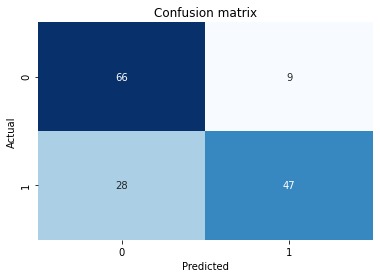

In [8]:
import seaborn as sns
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, fmt = 'd', annot = True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
precision = cm[1][1]/(cm[1][1] + cm[0][1])
print("Precision of the network = ", precision*100,"%")

Precision of the network =  83.92857142857143 %


**Localisation**

We are going to see a method to locate the area where pneumonia is detected, on one ct-scan

In [ ]:
Id = df['patientId'][2355]
dcm_file = 'stage_2_train_images/%s.dcm' % Id
dcm_data = pydicom.read_file(dcm_file)

print('patient', 2355, 'label: ', df['Target'][2355])

patient 2355 label:  1


(-0.5, 1023.5, 1023.5, -0.5)

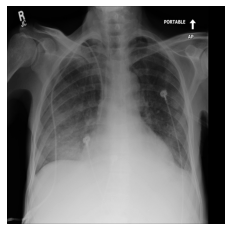

In [ ]:
image = dcm_data.pixel_array
pylab.imshow(image, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [ ]:
#resize the image so it has the same dimension as the ones used for train and test stages
resized = resize(image,(256,256))

In [ ]:
#cut the image in 16 equal parts
im_1 = resized[0:64, 0:64]
im_2 = resized[0:64, 64:128]
im_3 = resized[0:64, 128:192]
im_4 = resized[0:64, 192:256]

im_5 = resized[64:128, 0:64]
im_6 = resized[64:128, 64:128]
im_7 = resized[64:128, 128:192]
im_8 = resized[64:128, 192:256]

im_9 = resized[128:192, 0:64]
im_10 = resized[128:192, 64:128]
im_11 = resized[128:192, 128:192]
im_12 = resized[128:192, 192:256]

im_13 = resized[192:256, 0:64]
im_14 = resized[192:256, 64:128]
im_15 = resized[192:256, 128:192]
im_16 = resized[192:256, 192:256]

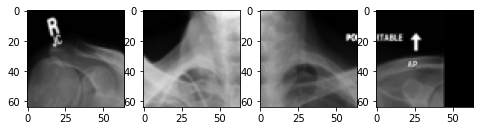

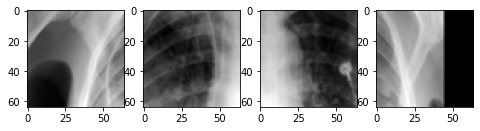

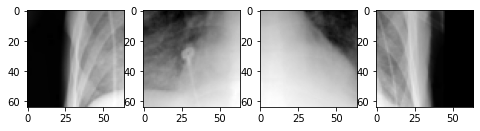

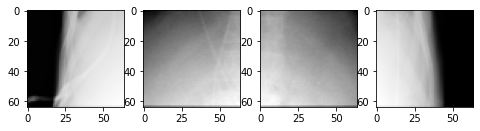

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,4,1)
plt.imshow(im_1,cmap=plt.cm.gray)
plt.subplot(1,4,2)
plt.imshow(im_2,cmap=plt.cm.gray)
plt.subplot(1,4,3)
plt.imshow(im_3,cmap=plt.cm.gray)
plt.subplot(1,4,4)
plt.imshow(im_4,cmap=plt.cm.gray)

plt.figure(figsize=(8,8))
plt.subplot(1,4,1)
plt.imshow(im_5,cmap=plt.cm.gray)
plt.subplot(1,4,2)
plt.imshow(im_6,cmap=plt.cm.gray)
plt.subplot(1,4,3)
plt.imshow(im_7,cmap=plt.cm.gray)
plt.subplot(1,4,4)
plt.imshow(im_8,cmap=plt.cm.gray)

plt.figure(figsize=(8,8))
plt.subplot(1,4,1)
plt.imshow(im_9,cmap=plt.cm.gray)
plt.subplot(1,4,2)
plt.imshow(im_10,cmap=plt.cm.gray)
plt.subplot(1,4,3)
plt.imshow(im_11,cmap=plt.cm.gray)
plt.subplot(1,4,4)
plt.imshow(im_12,cmap=plt.cm.gray)

plt.figure(figsize=(8,8))
plt.subplot(1,4,1)
plt.imshow(im_13,cmap=plt.cm.gray)
plt.subplot(1,4,2)
plt.imshow(im_14,cmap=plt.cm.gray)
plt.subplot(1,4,3)
plt.imshow(im_15,cmap=plt.cm.gray)
plt.subplot(1,4,4)
plt.imshow(im_16,cmap=plt.cm.gray)

plt.show()

In [ ]:
#add the images into a list (we don't need im_1, im_4 and im_13 to im_16 since there is no lungs in those parts)
cut_images=[]
cut_images.append(im_2)
cut_images.append(im_3)
cut_images.append(im_5)
cut_images.append(im_6)
cut_images.append(im_7)
cut_images.append(im_8)
cut_images.append(im_9)
cut_images.append(im_10)
cut_images.append(im_11)
cut_images.append(im_12)

In [ ]:
cut_images_resized = []
for i in cut_images : 
  #resize the image parts to 256x256 since the size changed after the image was cut
  i_resize = resize(i,(256,256))
  cut_images_resized.append(i_resize)

In [ ]:
#add images in an array so it is compatible with the model
cut_data = np.array(cut_images_resized)

In [ ]:
#reshape the data
cut_data = cut_data.reshape(cut_data.shape[0], cut_data.shape[1], cut_data.shape[2], 1)

In [ ]:
#make prediction as for the test set
pred = model.predict(cut_data)

In [ ]:
predict_class = np.argmax(pred, axis=1)
prediction = np.asarray(predict_class).astype('float32').reshape((-1,1))

In [ ]:
for i in range(11):
  if prediction[i]==1:
    print('Pneumonia detected in part ',i )

#part 0 = im_2
#part 1 = im_3
#part 2 = im_5
#part 3 = im_6
#...
#part 9 = im_12

Pneumonia detected in part  0
Pneumonia detected in part  4
Pneumonia detected in part  5
Pneumonia detected in part  6
Pneumonia detected in part  8
